# Lab 4

**Joseph Livesey**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal
import h5py

plt.rcParams["figure.figsize"] = (20, 10)

## Problem 1
In this first section, we are interested in extracting the background distribution from a set of satellite gamma ray observations. We first download the data from the HDF5 file provided in the lab assignment and import it as a `numpy` array into our working environment.

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')
hf.keys()

<KeysViewHDF5 ['data']>

In [3]:
data = np.array(hf.get('data'))
data[:,0]

array([9.40680016e+08, 3.15000000e+02, 4.50000000e+01, 1.00000000e+01])

In [4]:
hf.close()

The array we've assembled, `data`, has 4 columns and 25 million rows:

| Time (GPS s) | Solar phase ($^\circ$) | Earth longitude ($^\circ$) | Particle counts |
| :---: | :---: | :---: | :---: |
| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |

We will first construct some plots in order to better understand our data. Since this is a large dataset, we should concern ourselves more with density than with exact locations of individual data points, therefore the best course of action is to make 2D histograms.

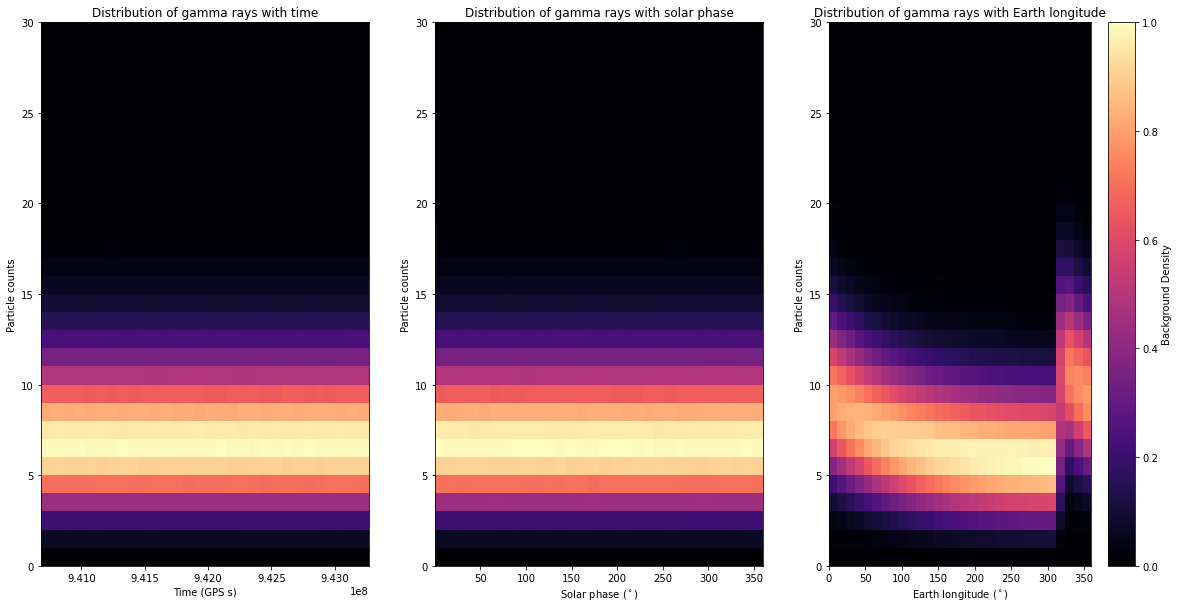

In [5]:
fig, ax = plt.subplots(1, 3)
cmap = 'magma'

ax[0].hist2d(data[0], data[3], [30, 30], cmap=cmap)
ax[0].set_title("Distribution of gamma rays with time")
ax[0].set_xlabel("Time (GPS s)")
ax[0].set_ylabel("Particle counts")

ax[1].hist2d(data[1], data[3], [30, 30], cmap=cmap)
ax[1].set_title("Distribution of gamma rays with solar phase")
ax[1].set_xlabel(r"Solar phase ($^\circ$)")
ax[1].set_ylabel("Particle counts")

ax[2].hist2d(data[2], data[3], [30, 30], cmap=cmap)
ax[2].set_title("Distribution of gamma rays with Earth longitude")
ax[2].set_xlabel("Earth longitude ($^\circ$)")
ax[2].set_ylabel("Particle counts")

plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax[2], label="Background Density");

As a function of time (over several days), the distribution of particle counts is roughly constant. The same is true in terms of the solar phase. Plotted against the Earth longitude, however, the distribution of cosmic rays changes over time, jumping up discretely at $\sim 300^\circ$. So, the background distribution is time-dependent, but fluctuates on small timescales, *i.e.*, the orbital period of the satellite, 90 minutes. There is no apparent signal contamination. Let $p(k, \phi)$ be the probability mass distribution of the background, with $k$ the number of particle counts and $\phi$ the instantaneous Earth longitude of the satellite. From the counts vs. time histogram, this looks roughly Poissonian at any given $\phi$. This makes sense, since a random variable with the Poisson distribution counts the number of times some event occurs in a given interval. Let $\mu(\phi)$ be the average background at a given longitude. From visual inspection of the counts vs. Earth longitude histogram, the time dependence seems like exponential decay. The overall background is given by the function

$$ p(k, \phi) = \frac{\mu(\phi)^k}{k!} e^{-\mu(\phi)}, \quad \mu(\phi) = \frac{6}{534} e^{ -\left ( \phi - 310^\circ \right )} + 5, \quad \phi \in [0, 360^\circ). $$

The scaling factor out front, $6/534$, was obtained through a trial-and-error process.

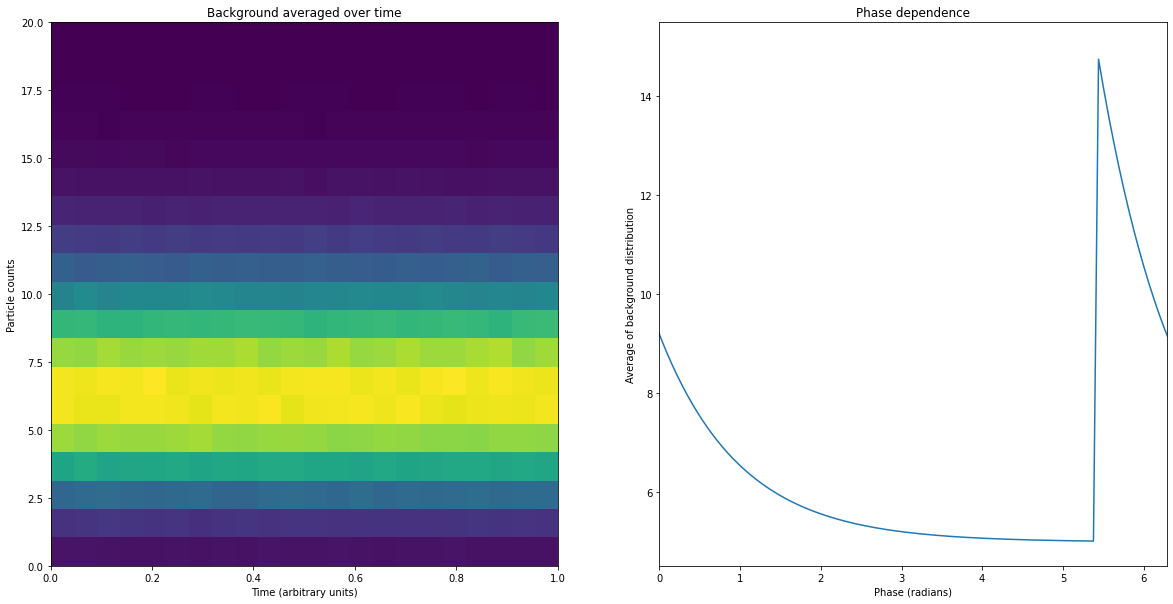

In [6]:
phis = np.linspace(-10*np.pi, 10*np.pi, 1000)
avgs = [(10/534) * np.exp(-(phi - 310*np.pi/180) % (2*np.pi)) + 5.0 for phi in phis]

ones = np.linspace(0, 1.0, 1000000)
pois = stats.poisson.rvs(mu=7, size=1000000)

fig, ax = plt.subplots(1, 2)
ax[0].hist2d(ones, pois, [22, 22])
ax[0].set_ylim(0, 20)
ax[0].set_title('Background averaged over time')
ax[0].set_xlabel('Time (arbitrary units)')
ax[0].set_ylabel('Particle counts')

ax[1].plot(phis, avgs)
ax[1].set_xlim(0, 2*np.pi)
ax[1].set_title('Phase dependence')
ax[1].set_xlabel('Phase (radians)')
ax[1].set_ylabel('Average of background distribution');

The above two plots show us the Poisson distribution at every value of the Earth longitude under our model, and the phase-dependence. Now, we combine them and compare the overall model to the data.

In [7]:
phis = np.linspace(0, 2*np.pi, 100000)
avgs = [(6/534) * np.exp(-(phi - 310*np.pi/180) % (2*np.pi)) + 5.0 for phi in phis]
pois = stats.poisson.rvs(mu=avgs, size=100000)

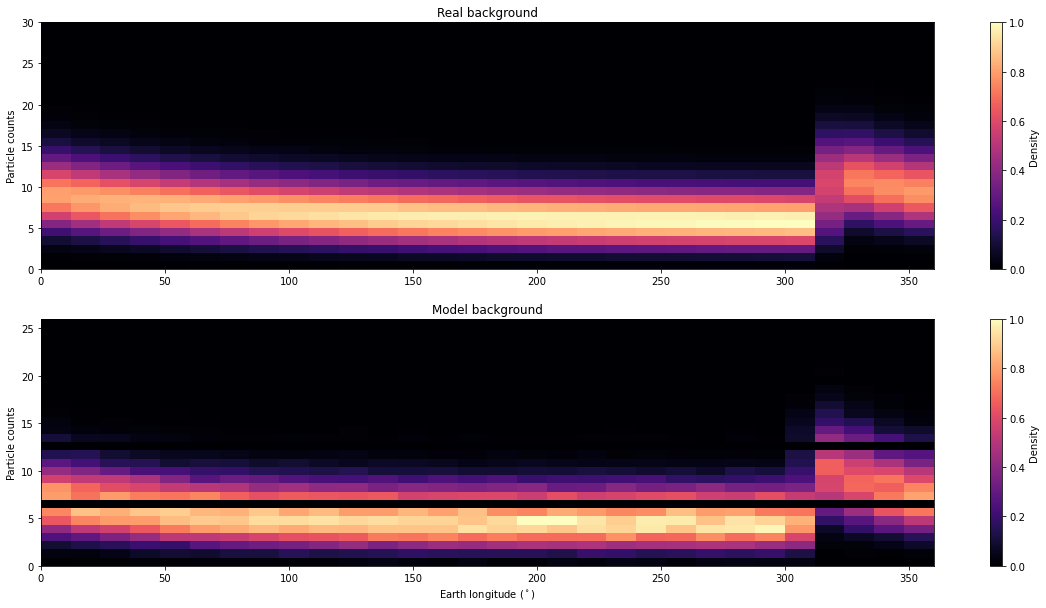

In [8]:
fig, ax = plt.subplots(2, 1)
cmap = 'magma'

ax[0].hist2d(data[2], data[3], [30, 30], cmap=cmap)
ax[0].set_title('Real background')
ax[0].set_ylabel('Particle counts')

ax[1].hist2d(phis * 180/np.pi, pois, [30, 30], cmap=cmap)
ax[1].set_title('Model background')
ax[1].set_xlabel(r'Earth longitude ($^\circ$)')
ax[1].set_ylabel('Particle counts')

for axis in ax:
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=axis, label='Density');

Our model is very similar to the real distribution. Let's compare the $5\sigma$ thresholds for different Earth longitudes. To do this we must obtain the pmfs of the background at various longitudes. At $\phi = 0$, for example, the pmf of the background distribution is

$$ \mu(0) = \exp \left ( \frac{310\pi}{180} \right ) + 5 \quad \Longrightarrow \quad p(k, 0) = \frac{\mu(0)^k}{k!} e^{-\mu(0)}. $$

Let's find the $5\sigma$ thresholds at $\phi = 0, \pi/3,$ and $31\pi/18$.

In [9]:
for phi in [0, np.pi/3, 31*np.pi/18]:
    prob = stats.norm.cdf(5.0)
    
    mu = (6/534) * np.exp(-(phi - 310*np.pi/180)) + 5.0
    val = stats.poisson.ppf(prob, mu=mu)
    
    print(phi, val)

0 25.0
1.0471975511965976 21.0
5.410520681182422 20.0


The respective thresholds in terms of particle counts at these longitudes are roughly 25, 21, and 20.

## Problem 2
Now, we will take a look at some stacked telescope images.

In [10]:
hf = h5py.File('images.h5', 'r')
hf.keys()

<KeysViewHDF5 ['image1', 'imagestack']>

In [11]:
image1 = np.array(hf.get('image1'))
imagestack = np.array(hf.get('imagestack'))
hf.close()

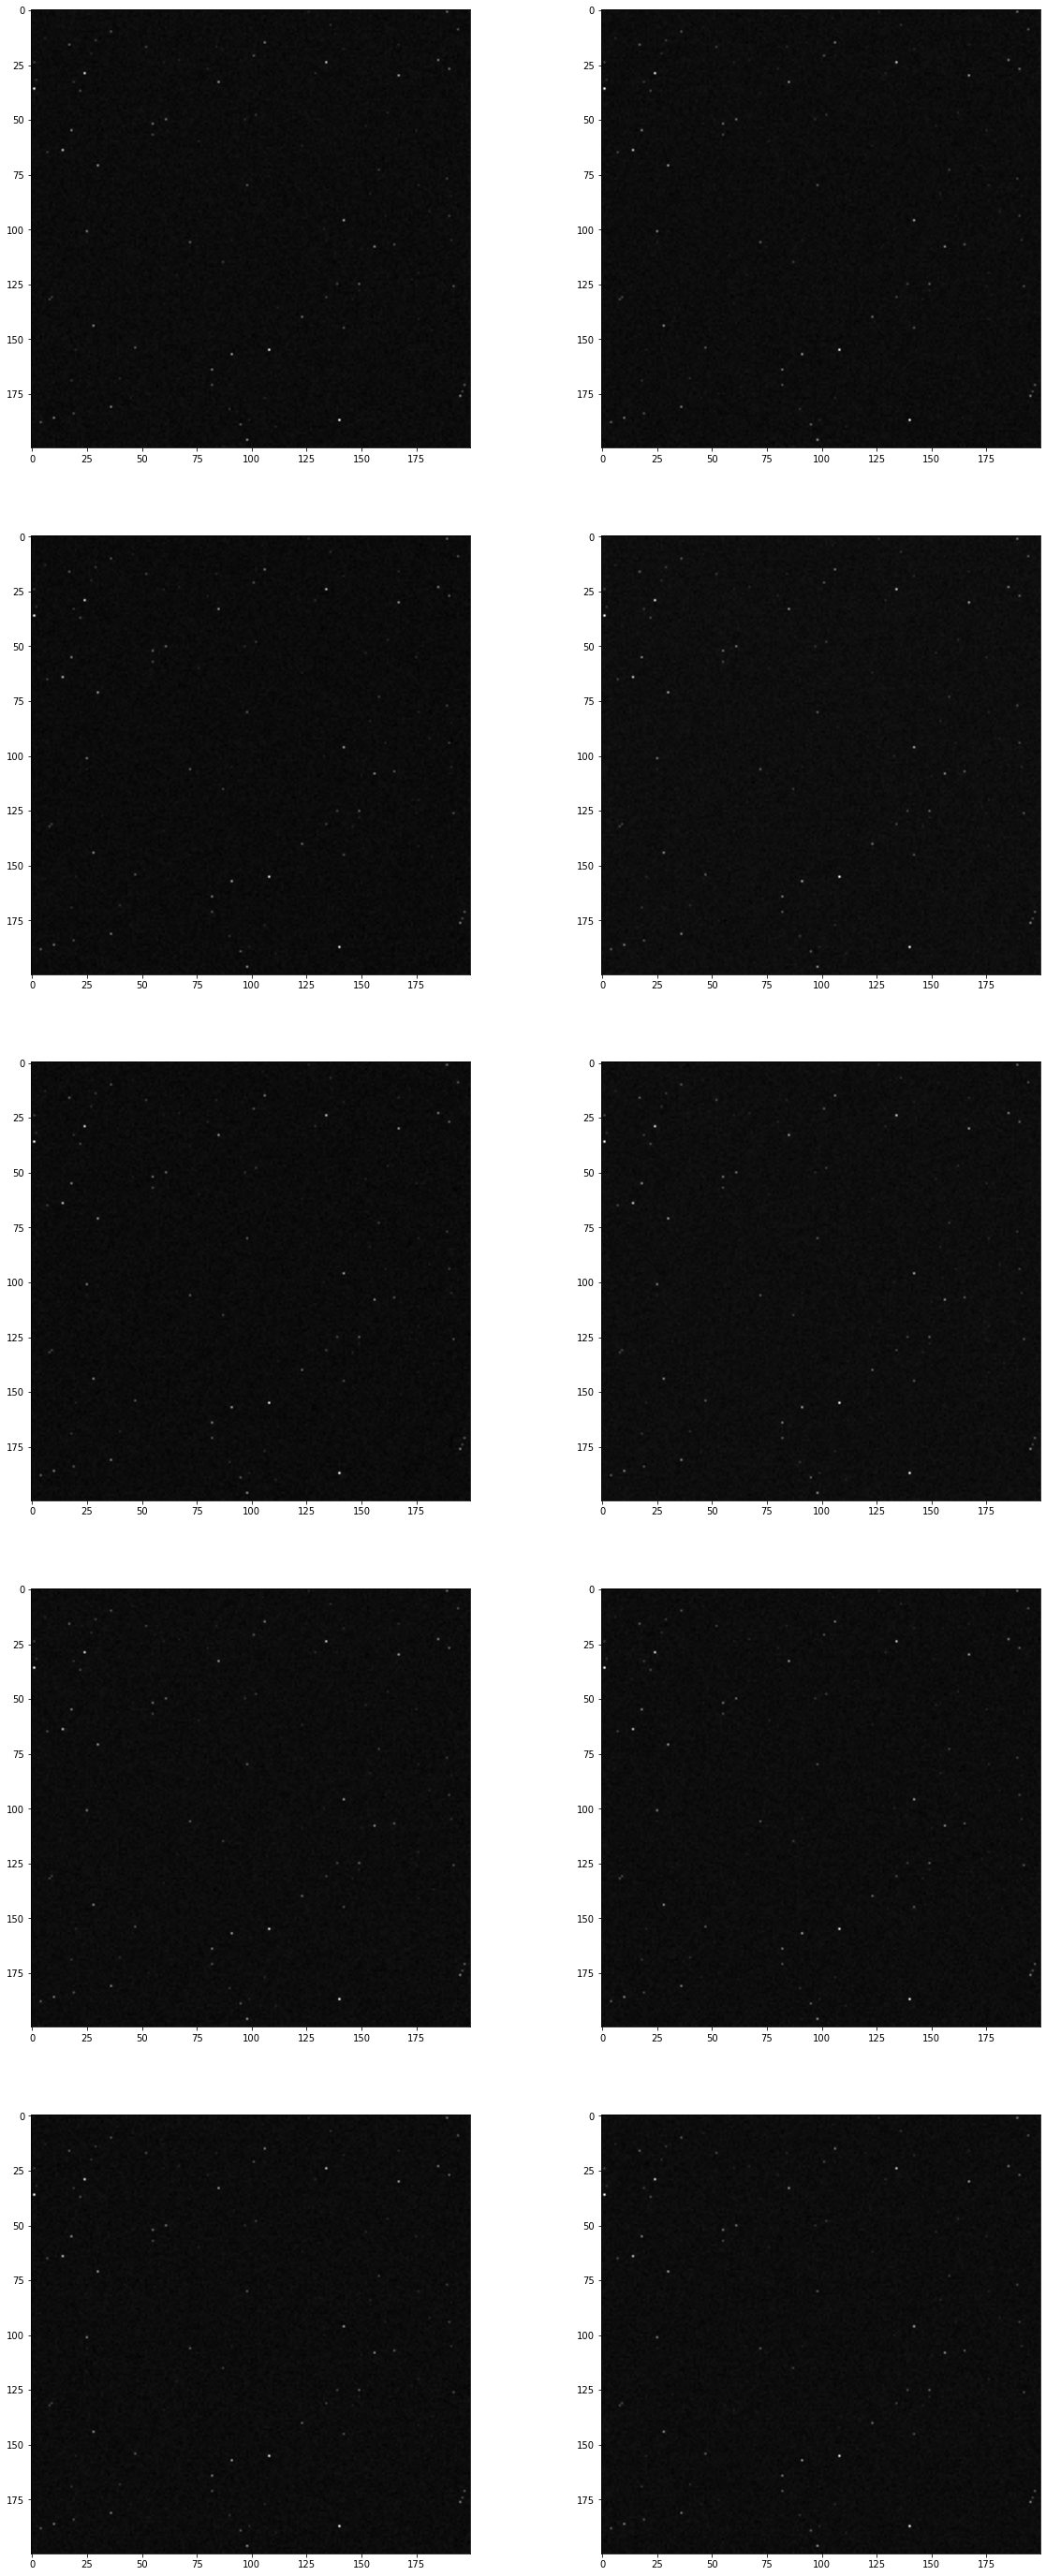

In [12]:
fig, ax = plt.subplots(5, 2, figsize=(20, 50))
cmap = 'gray'

ax[0, 0].imshow(imagestack[:,:,0], cmap=cmap)
ax[0, 1].imshow(imagestack[:,:,1], cmap=cmap)
ax[1, 0].imshow(imagestack[:,:,2], cmap=cmap)
ax[1, 1].imshow(imagestack[:,:,3], cmap=cmap)
ax[2, 0].imshow(imagestack[:,:,4], cmap=cmap)
ax[2, 1].imshow(imagestack[:,:,5], cmap=cmap)
ax[3, 0].imshow(imagestack[:,:,6], cmap=cmap)
ax[3, 1].imshow(imagestack[:,:,7], cmap=cmap)
ax[4, 0].imshow(imagestack[:,:,8], cmap=cmap)
ax[4, 1].imshow(imagestack[:,:,9], cmap=cmap);

Let's compare these images, in order to find any transient objects in the data (fast-moving objects that show up in one image but not the others). We must construct a background by looking at the distribution of pixel brightnesses when we subtract one of the images from another.

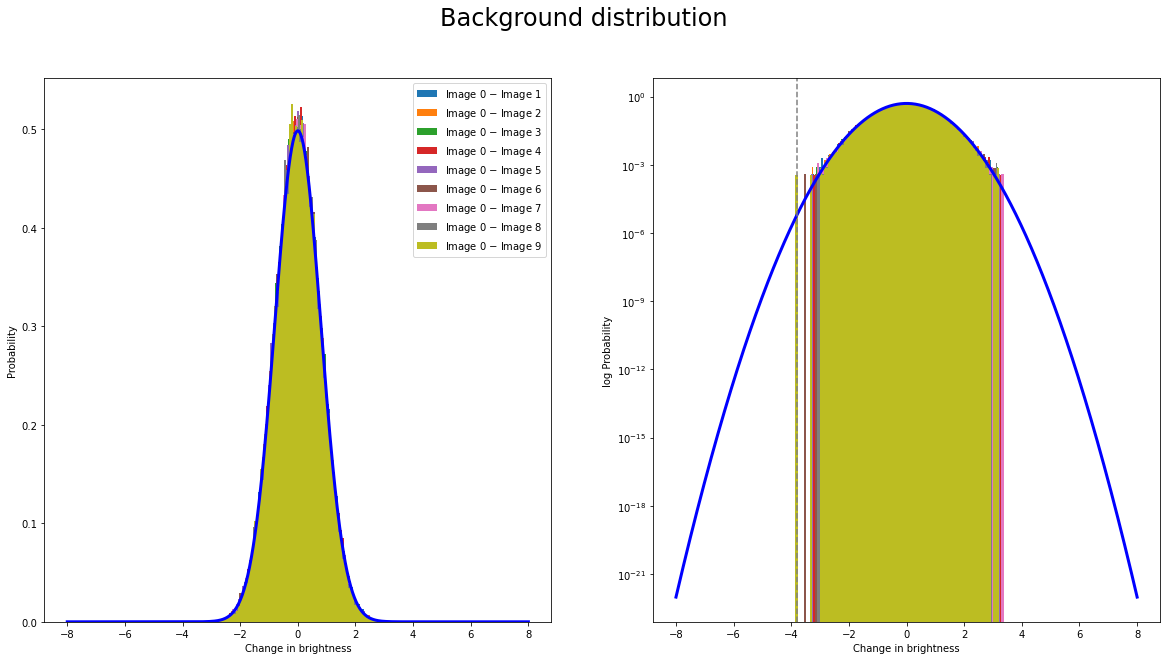

In [13]:
def background_hist(image):
    background = imagestack[:,:,0] - imagestack[:,:,image]
    return [val for line in background for val in line]

xx = np.linspace(-8., 8., 1000)

fig, ax = plt.subplots(1, 2)
for axis in ax:
    for n in range(9):
        axis.hist(background_hist(n+1), bins=100, density=True, label=r'Image 0 $-$ Image '+str(n+1))
    axis.plot(xx, stats.norm.pdf(xx, scale=0.8), c='b', lw=3)
    axis.set_xlabel('Change in brightness')
ax[1].axvline(-3.8, c='gray', ls='--')
ax[1].set_yscale('log')
ax[0].set_ylabel('Probability')
ax[1].set_ylabel('log Probability')
ax[0].legend(loc=0)
plt.suptitle('Background distribution', fontsize=24);

As shown above, the background brightness distribution is well-fit by a zero-mean Gaussian with $\sigma=0.8$. In this plot, we've derived a background ten times, each time subtracting one of the other images from the first. These do not, of course, represent a comprehensive list of ways in which we might have derived a background, but this is enough to convince us that if we subtract any image from another, the resulting distribution will be well-fit by this curve.

We can see here that in Image 9 (corresponds to the foremost, beige distribution) there is a signal at a brightness difference of about $-3.8$ which defies the background distribution. The location is shown on the second plot by the grey dashed line. Now we will calculate the sigma value of this detection.

In [14]:
prob = stats.norm.cdf(-3.8, scale=0.8)
stats.norm.ppf(prob)

-4.749999999999999

This is a $\sim 4.7\sigma$ signal, almost high enough to claim a detection. In this case, if we could claim a detection, we would be confident that we had seen a transient, *i.e.*, an object moving quickly enough across the sky that we see it in one image and not the others. This is because we are looking at the background that we obtain by subtracting the images from each other. If we were to look at the distribution of brightnesses across a single image and derive a background distribution from that, any signals we found to compare with that distribution would be faint stars (they could be transients too, though). This is why my partner and I should have distinct background PDFs: because I hunted for transients and he hunted for faint stars.